In [1]:
!pip install cvxpy

In [2]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

## 1. 从 xy_train.csv 中读取训练数据

In [4]:
## load data
## csv数据文件没有头，所以header=None
xy_train_origin = pd.read_csv('xy_train.csv',header=None,names=['x1','x2','y'])
xy_test_origin = pd.read_csv('xy_test.csv',header=None,names=['x1','x2','y'])

## data dealing
x_train = np.array(xy_train_origin[['x1','x2']])
y_train = np.array(xy_train_origin[['y']])

x_test = np.array(xy_test_origin[['x1','x2']])
y_test = np.array(xy_test_origin[['y']])

## data setting
p_train = x_train.shape[1]#feature的维度
p_test = x_test.shape[1]
sample_size_train = x_train.shape[0]
sample_size_test = x_test.shape[0]

## 2. 用CVXPY求解SVM问题

特征空间中找到一个最优的超平面来进行分类，并且间隔最大
https://blog.csdn.net/qq_53123067/article/details/136060974#:~:text=支持向量机（Support%20Vector%20Machine，SVM）是一种经典的监督学习算法，用于解决二分类和多分类问题%E3%80%82,其核心思想是通过在特征空间中找到一个最优的超平面来进行分类，并且间隔最大%E3%80%82%20SVM能够执行线性或非线性分类、回归，甚至是异常值检测任务%E3%80%82%20它是机器学习领域最受欢迎的模型之一%E3%80%82

In [5]:
## Construct the problem
beta = cp.Variable((p_train,1))
beta0 = cp.Variable()
xi = cp.Variable((sample_size_train,1))

objective = cp.Minimize(cp.sum_squares(beta) / 2 + cp.sum(xi))
constraints = [xi>=0 , xi>=1 - cp.multiply(y_train, x_train @ beta + beta0)]

## Solve the problem
prob_train = cp.Problem(objective, constraints)
result = prob_train.solve()
print(f"Optimal value: {result:.4f}")
print(f"Beta values:\n{beta.value}")
print(f"Beta0 value: {beta0.value:.4f}")

Optimal value: 36.7489
Beta values:
[[1.41967191]
 [1.24607477]]
Beta0 value: -2.8237


## 3. 画出训练数据与决策边界

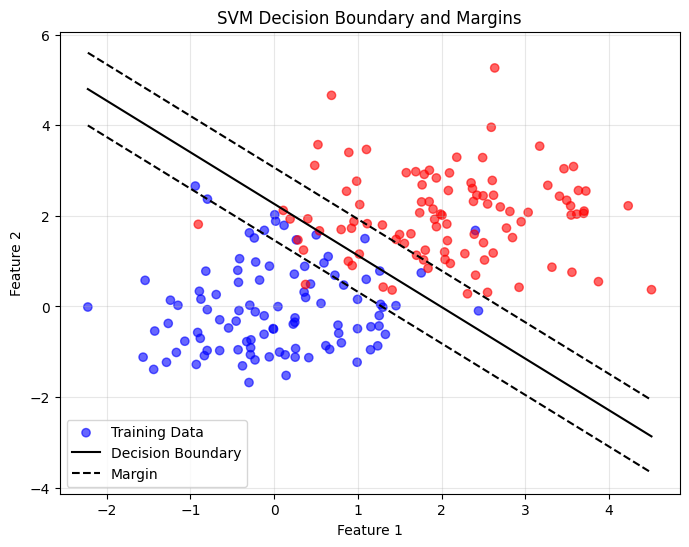

In [9]:
## Plot the data set and decision boundary
## beta0+beta1'x=0,beta0+beat11x1+beta12x2=0,x2=-(beta0+beat11x1)/beta12
# Set up the plot
plt.figure(figsize=(8, 6))

# Draw the scatter plot of training data points
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap='bwr', alpha=0.6, label='Training Data')

# Generate points for decision boundary
xx = np.linspace(np.min(x_train[:,0]), np.max(x_train[:,0]), 100)

# Calculate decision boundary and margins
beta0_val = beta0.value
beta_val = beta.value
yy = -(beta_val[0] * xx + beta0_val) / beta_val[1]  # Decision boundary
yy_up = (1 - (beta_val[0] * xx + beta0_val)) / beta_val[1]  # Upper margin (add 1)
yy_down = (-1 - (beta_val[0] * xx + beta0_val)) / beta_val[1]  # Lower margin (substract 1)

# Plot decision boundary and margins
plt.plot(xx, yy, 'k-', label='Decision Boundary')
plt.plot(xx, yy_up, 'k--', label='Margin')
plt.plot(xx, yy_down, 'k--')

# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary and Margins')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

## 4. 构造另一种形式的SVM问题

In [10]:
## Construct the problem
x_train_new = y_train * x_train

omega = cp.Variable((sample_size_train,1))

# Objective: maximize -1/2 * ||X'ω||^2 + 1'ω 
objective2 = cp.Maximize(-cp.sum_squares(x_train_new.T @ omega) / 2 + cp.sum(omega))

# Box constraints and equality constraint
constraints2 = [
    omega >= 0,
    omega <= 1, 
    cp.sum(cp.multiply(omega, y_train)) == 0
]

## Solve the problem
prob2_train = cp.Problem(objective2, constraints2)
result2 = prob2_train.solve(solver=cp.ECOS)

print(f"Original optimal value: {result:.4f}")
print(f"Dual optimal value: {result2:.4f}")

Original optimal value: 36.7489
Dual optimal value: 36.7489


/Users/hanhan/anaconda3/envs/Optimization/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


## 5. 选择不同参数C，对每个C求解SVM，并画出决策边界，
 并在测试集xy_test.csv中计算错误率，画出错误率（y轴）和参数C（x轴，log-scale）的关系

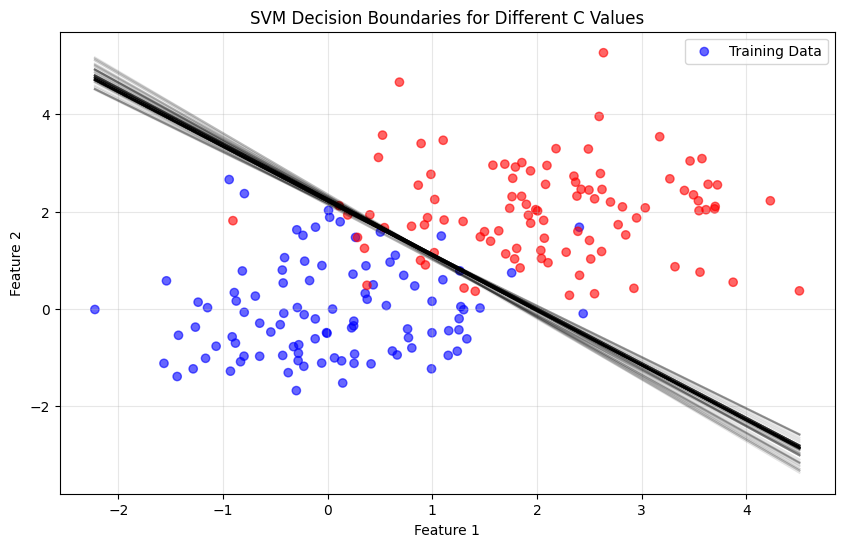

In [11]:
## 5. 选择不同参数C，对每个C求解SVM，并画出决策边界，并在测试集xy_test.csv中计算错误率，画出错误率（y轴）和参数C（x轴，log-scale）的关系
# Define variables for SVM model
beta_C = cp.Variable((p_train,1))  # Weight vector
beta0_C = cp.Variable()  # Bias term
xi_C = cp.Variable((sample_size_train,1))  # Slack variables
para_C = cp.Parameter(nonneg=True)  # Regularization parameter

# Define objective function and constraints
objective_C = cp.Minimize(cp.sum_squares(beta_C)/2 + para_C * cp.sum(xi_C))
constraints_C = [
    xi_C >= 0,  # Non-negativity constraint on slack variables
    xi_C >= 1 - cp.multiply(y_train, x_train @ beta_C + beta0_C)  # Margin constraints
]

# Create the optimization problem
prob_C = cp.Problem(objective_C, constraints_C)

# Compute trade-off curve and record training/test errors
TRIALs = 101
train_error = np.zeros(TRIALs)
test_error = np.zeros(TRIALs)
C_vals = np.logspace(-4, 4, TRIALs, base=2)  # Range of C values to try
beta_vals = []
beta0_vals = []

# Solve SVM for different C values
for i in range(TRIALs): #找100个点
    para_C.value = C_vals[i]
    prob_C.solve(solver=cp.ECOS)
    
    # Calculate prediction errors
    train_pred = x_train.dot(beta_C.value) + beta0_C.value
    test_pred = x_test.dot(beta_C.value) + beta0_C.value
    
    train_error[i] = np.mean(np.sign(train_pred) != y_train)
    test_error[i] = np.mean(np.sign(test_pred) != y_test)
    
    beta_vals.append(beta_C.value)
    beta0_vals.append(beta0_C.value)

# Visualize decision boundaries
plt.figure(figsize=(10, 6))
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap='bwr', alpha=0.6, label='Training Data')

# Plot decision boundaries for different C values
xx = np.linspace(np.min(x_train[:,0]), np.max(x_train[:,0]), 100)
for i in range(TRIALs):
    yy = -(beta_vals[i][0] * xx + beta0_vals[i])/beta_vals[i][1]
    plt.plot(xx, yy, 'k-', alpha=0.1)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundaries for Different C Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

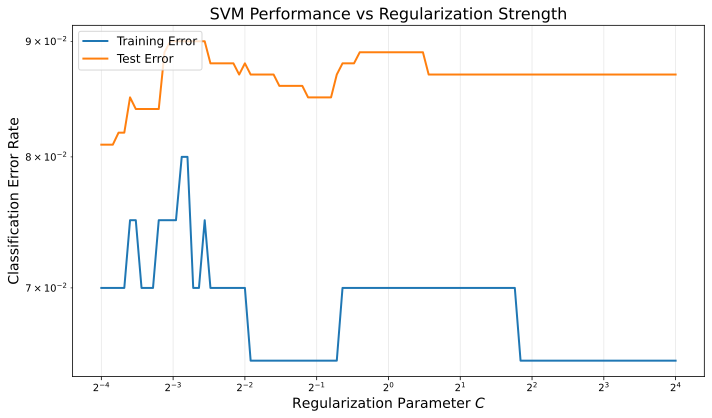

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(10, 6))
plt.plot(C_vals, train_error, label="Training Error", linewidth=2)
plt.plot(C_vals, test_error, label="Test Error", linewidth=2)
plt.xscale('log', base=2)
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=12)
plt.xlabel(r"Regularization Parameter $C$", fontsize=14)
plt.ylabel("Classification Error Rate", fontsize=14)
plt.title("SVM Performance vs Regularization Strength", fontsize=16)
plt.tight_layout()
plt.show()